In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from IPython.display import clear_output
import torch
import torch.nn as nn
import time
from numpy.random import shuffle

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def min_max_norm(x):
    mx = np.min(x)
    return (x - mx)/(np.max(x)-mx)

def std_norm(x):
    return (x - np.mean(x))/np.std(x)

def mae(y_true, predictions):
    return nn.functional.l1_loss(y_true, predictions).item()

def plot_training(tr_loss, tr_mae, val_loss, val_mae):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].set_title('MAE')
    axes[0].plot(tr_mae, label='Training MAE')
    axes[0].plot(val_mae, label='Validation MAE')
    axes[0].set_xlabel('n epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title('Loss')
    axes[1].plot(tr_loss, label='Training loss')
    axes[1].plot(val_loss, label='Validation loss')
    axes[1].set_xlabel('n epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device, scheduler=None, max_target=1):
    train_loss = []
    val_loss = []
    train_mae = []
    val_mae = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_mae = []
        ep_val_mae = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_mae.append(mae(y_batch*max_target, model(X_batch)*max_target))

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
                out = model(X_batch)
                loss = loss_fn(out, y_batch)

                ep_val_loss.append(loss.item())
                ep_val_mae.append(mae(y_batch*max_target, out*max_target))

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_mae.append(np.mean(ep_train_mae))

        val_loss.append(np.mean(ep_val_loss))
        val_mae.append(np.mean(ep_val_mae))

        clear_output(True)

        plot_training(train_loss, train_mae, val_loss, val_mae)

        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t training MAE: {train_mae[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation MAE: {val_mae[-1]:.3f}")

        if scheduler is not None:
                scheduler.step()

    return train_loss, train_mae, val_loss, val_mae

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y, y_true, eps=1e-7):
        return (nn.functional.l1_loss(y, y_true) + torch.sqrt_(nn.functional.mse_loss(y, y_true)))/2


In [2]:
class ResBlock(nn.Module):
    def __init__(self, input_size=100, expanded_size=200, output_size=100):
        super(self.__class__, self).__init__()

        activation = nn.Hardswish()

        self.input_size = input_size
        self.expanded_size = expanded_size
        self.output_size = output_size

        self.model = nn.Sequential(
            nn.Linear(input_size, expanded_size),
            nn.BatchNorm1d(expanded_size, eps = 1e-3, momentum = 0.1),
            activation,
            nn.Linear(expanded_size, output_size),
            nn.BatchNorm1d(output_size, eps = 1e-3, momentum = 0.1),
            activation,
        )

    def forward(self, inp):
        out = self.model(inp)
        if self.input_size == self.output_size:
            out += inp
        return out

class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(self.__class__, self).__init__()
        activation = nn.Hardswish()
        self.model = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.BatchNorm1d(input_size*2, eps = 1e-3, momentum = 0.1),
            activation,
            nn.Linear(input_size*2, input_size*4),
            nn.BatchNorm1d(input_size*4, eps = 1e-3, momentum = 0.1),
            activation,
            nn.Linear(input_size*4, input_size*8),
            nn.BatchNorm1d(input_size*8, eps = 1e-3, momentum = 0.1),
            activation,
            nn.Linear(input_size*8, input_size*16),
            nn.BatchNorm1d(input_size*16, eps = 1e-3, momentum = 0.1),
            activation,

            nn.Linear(input_size*16, 1),
            # nn.Sigmoid()
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [3]:
test_data = pd.read_csv(filepath_or_buffer='test.csv', na_values=["?"])
test_data_IDs = test_data.loc[:, "Id"]
test_data = test_data.drop("Id", axis=1)
test_cat_features_mask = (test_data.dtypes == "object").values
normalizer = preprocessing.StandardScaler()
test_X_real = test_data[test_data.columns[~test_cat_features_mask]]
mis_replacer = KNNImputer(n_neighbors=5, weights='distance')
test_X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(test_X_real), columns=test_X_real.columns)
test_X_no_mis_norm = normalizer.fit_transform(test_X_no_mis_real)
test_X_cat = test_data[test_data.columns[test_cat_features_mask]].fillna("")

dataset = pd.read_csv(filepath_or_buffer='train.csv', na_values=["?"]).drop("Id", axis=1)
data = dataset.drop('SalePrice', axis=1)
target = dataset.values[:, -1].astype(np.float)
cat_features_mask = (data.dtypes == "object").values
normalizer = preprocessing.StandardScaler()
X_real = data[data.columns[~cat_features_mask]]
mis_replacer = KNNImputer(n_neighbors=5, weights='distance')
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
X_no_mis_norm = normalizer.fit_transform(X_no_mis_real)
X_cat = data[data.columns[cat_features_mask]].fillna("")

X_cat_one_hot = pd.get_dummies(pd.concat((X_cat, test_X_cat), axis = 0), drop_first=True).values[:len(X_cat)]

max_target = np.max(target)
target_norm = target / max_target
# target_log = np.log10(target)

X = np.concatenate([X_no_mis_norm, X_cat_one_hot], axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.1)
test_X_cat_one_hot_whole_pack = pd.get_dummies(pd.concat((test_X_cat, X_cat), axis = 0), drop_first=True)
test_X_cat_one_hot = test_X_cat_one_hot_whole_pack.values[:len(test_X_cat)]
test_X = np.concatenate([test_X_no_mis_norm, test_X_cat_one_hot], axis=1)
test_X_frame = pd.DataFrame(data=test_X, columns=test_X_no_mis_real.columns.append(test_X_cat_one_hot_whole_pack.columns))

# X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.1)

split_index = int(len(X) * 0.9)
shuffle(X)
train_loader = torch.utils.data.DataLoader(list(zip(X,target))[:split_index],
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(list(zip(X,target))[split_index:],
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=0)

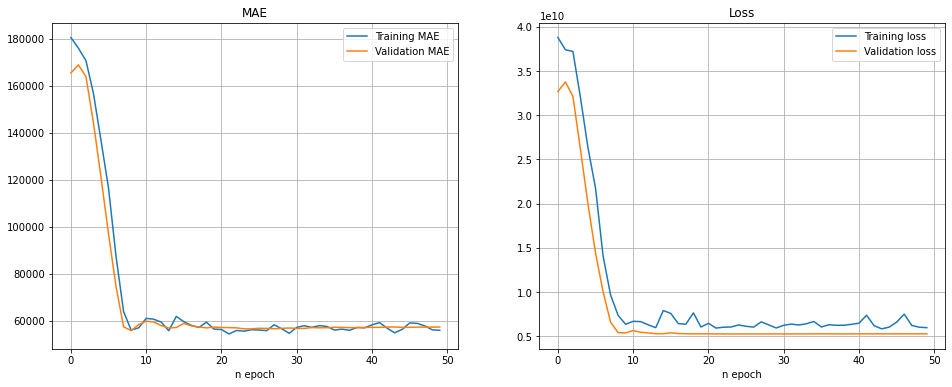

	 training loss: 5955332437.333333
	 training MAE: 55885.629557
	 validation loss: 5260571648.000000
	 validation MAE: 57267.762


In [4]:
n_epochs = 50
model = TinyNeuralNetwork(X.shape[1]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr = 10e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, eta_min=1e-4, T_max=n_epochs, last_epoch=-1)
loss_func = nn.MSELoss()

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs, scheduler=scheduler, max_target=1)

In [73]:
model = model.cpu()
test_out = model(torch.tensor(test_X).float())
test_out = 10**test_out
test_out = test_out.detach().numpy().squeeze(1)

result = pd.DataFrame(data=np.stack((test_data_IDs, test_out), axis=1).astype(dtype=np.int), columns=["Id", "SalePrice"])
result.to_csv('result.csv', index=False)

Results are pretty bad, lets try something more complicated than simple fully connected nn (tabNet for example).